# Lab 3: Diffusion Models

Diffusion models are generative models designed to learn a diffusion process that generates the probability distribution of a given dataset.
These models have shown significant advancements in the field of image generation, with examples such as MidJourney and DALL-E 3.
These models are often conditioned on text or other modalities for better flexilibity.
In this lab, we will learn more about diffusion models, and particularly about their sampling process.

## 0. Preconfiguration

We check that a GPU is available.

In [1]:
import torch

torch.cuda.is_available()

True

If you use Google Colab and the above code returns False, click on `Runtime`, `Change runtime type`, and choose `T4 GPU`. Then run the notebook again from the start.

We install the required libaries.

In [2]:
%pip install --quiet --upgrade diffusers accelerate mediapy

We import useful libraries.

In [3]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import imageio.v3 as iio
from pathlib import Path
from diffusers import AutoPipelineForText2Image, UNet2DModel
import mediapy as media

We initialize the directories.

In [4]:
sdxl_dir = Path('SDXL')
sdxl_dir.mkdir(exist_ok=True)
results_dir = Path('results')
results_dir.mkdir(exist_ok=True)
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

## 1. Pre-trained diffusion models

For demonstration, feel free to experiment with Stable Diffusion XL, an open-source diffusion model with strong performance.
Running this cell should take about 3 minutes.

You can change the prompt or the number of inference steps.
The intermediate images of the diffusion process are stored in the folder `SDXL`.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

a photo of Pikachu fine dining with a view to the Eiffel Tower

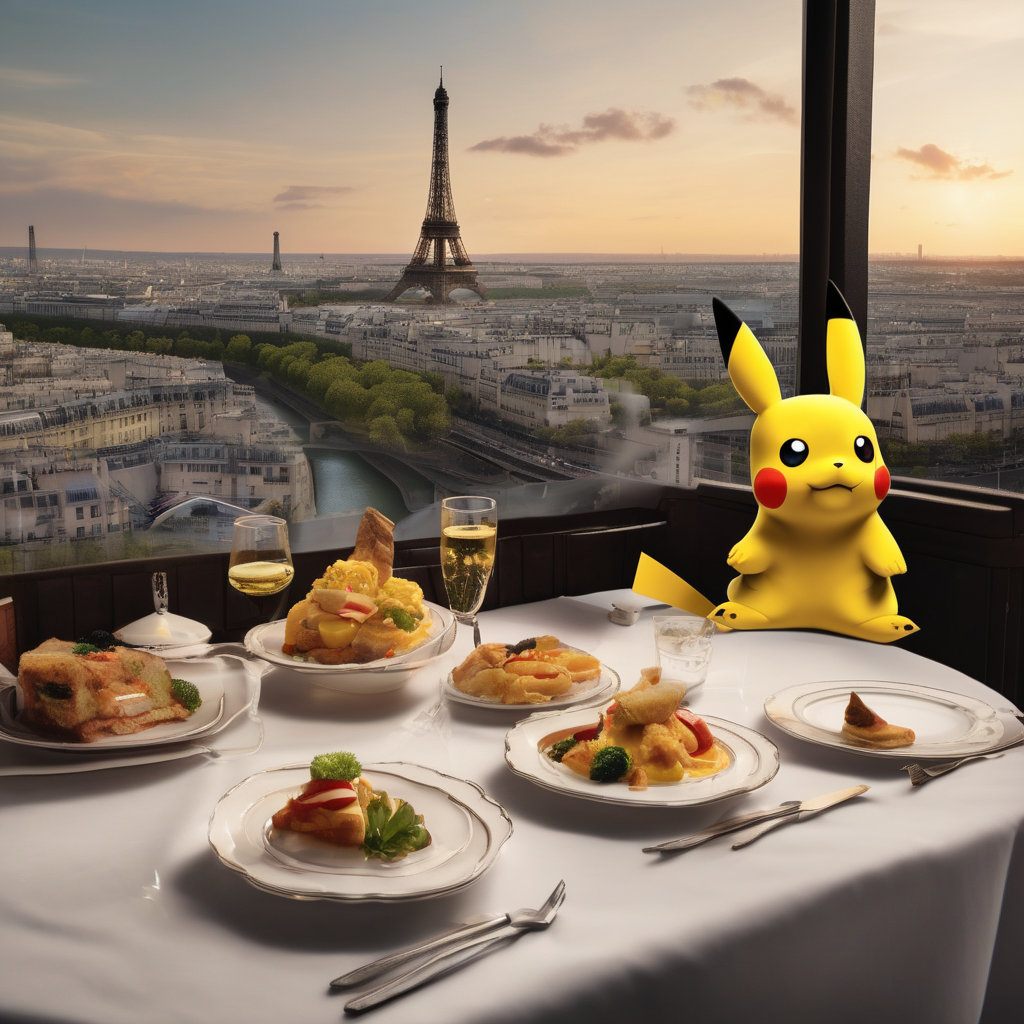

In [5]:
prompt = "a photo of Pikachu fine dining with a view to the Eiffel Tower"
num_inference_steps = 50

sdxl_images = []

def callback(pipe, step, timestep, callback_kwargs):
    # We save the image every 5 steps
    if step % 5 == 0 or step == num_inference_steps - 1:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            pipe.upcast_vae()
            latents = latents.to('cuda')
            image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
            pipe.vae.to(dtype=torch.float16)
            image = pipe.image_processor.postprocess(image, output_type="pil")[0]
            sdxl_images.append(image)
            image.save(sdxl_dir / f'iter_{step}.png')
    return callback_kwargs

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    callback_on_step_end=callback,
)

media.show_image(sdxl_images[-1], title=prompt)

## 2. Dataset loading

We will train a diffusion model on MNIST, a dataset of digits that we already used in Lab 2.

We define hyperparameters and constants.

In [6]:
height, width = 28, 28
X_dim = height * width
n_channels = 1 # Images are grayscale so only one channel

n_epochs = 3 # Number of full passes through the dataset
log_interval = 5 # How often to show loss statistics and save samples
n_T = 400 # Number of steps in the diffusion process
lrate = 2e-4 # Learning rate for the optimizer
batch_size = 128
device = 'cuda'

We load and plot the dataset

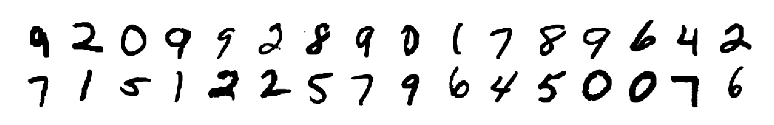

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
     # We normalize the data to have zero mean and unit standard deviation using precomputed values.
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_data = MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

def plot_images(images, ncols=16, axis=None):
    grid = torchvision.utils.make_grid(images, nrow=ncols)
    # In `make_grid`, `nrow` is a misnomer and represents the number of columns.
    if axis is None:
        fig, axis = plt.subplots(dpi=150)
    axis.imshow(grid[0], cmap='binary', vmin=0, vmax=1)
    axis.axis('off')

images = next(iter(train_loader))[0][:32]
plot_images(images)

## 3. The corruption process

Let's visualize the corruption process. First, we define a function that mixes an image with a certain amount of noise.

In [8]:
def corrupt(image, amount):
    noise = torch.randn_like(image)
    amount = amount.view(-1, 1, 1, 1) # Change shape so that broadcasting works
    return  image * (1 - amount) + noise * amount

As the amount of noise increases, it becomes more difficult to predict what the original image is.

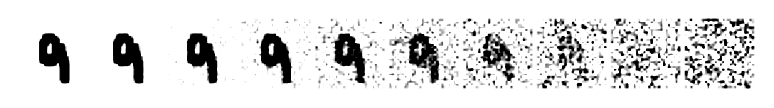

In [9]:
# We select the first images and repeat it 10 times
x = images[:1].repeat(10, 1, 1, 1)
# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noisy_x = corrupt(x, amount)
# Plotting the noised version
plot_images(noisy_x)

## 4. UNet: an image-to-image model

The principle behind diffusion models is to gradually transform noise into a structured sample (like an image).
The UNet architecture plays a central role in predicting the noise that needs to be removed at each step of the reverse diffusion process.
It takes a noisy image and a step as input, and predicts the noise that was added at the current step.
Once this noise is predicted, it can be subtracted from the noisy image, resulting in a less noisy image. This process is iterated, with the UNet making predictions at each step, gradually denoising the image until a coherent and structured output is obtained.
For this lab, we load a UNet that has already been carefully created for us.

In [10]:
def create_unet():
    return UNet2DModel(
        sample_size=(height, width),
        in_channels=1,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(64, 128, 128),
        down_block_types=('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
        up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    )

unet = create_unet().to(device)

Let's run the UNet on our first batch of data and random time steps.
We observe that the shape of the predictions is the same than the shape of the batch.

In [11]:
# We take the first batch from the training data.
first_batch = next(iter(train_loader))[0].to(device)
print('Shape of the batch:', first_batch.shape)
# We sample a random time step for each image in the batch.
time_step = torch.randint(1, n_T + 1, (first_batch.shape[0],)).to(device)
# We pass the batch through the UNet and get the predictions.
noise_prediction = unet(first_batch, time_step)['sample']
print('Shape of the predictions:', noise_prediction.shape)

Shape of the batch: torch.Size([128, 1, 28, 28])
Shape of the predictions: torch.Size([128, 1, 28, 28])


## 5. Training and sampling

We define the loss and the sampling process here.

First, we have to define different constants related to the schedule.
We do not require to understand their meaning in this course, but you can refer to [this paper](https://arxiv.org/abs/2006.11239) if you are interested.

In [1]:
#@title DDPM schedules

def ddpm_schedules(beta1: float, beta2: float, T: int):
    """
    Returns pre-computed schedules for DDPM sampling and training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

Secondly, the class `DDPM` implements the loss of the diffusion model in the method `forward` and the sampling process in the method `sample`.
We do not require to understand the details of these methods.
However, you can understand that:
- In `forward`, the loss encourages the model to learn to predict the noise that was applied to the input.
- In `sample`, the sampling process starts with noise and iterates over successive steps (400 in our case) to denoise the image until obtaining the final sample.

In [13]:
class DDPM(nn.Module):
    def __init__(self, eps_model, betas, n_T):
        super().__init__()
        self.eps_model = eps_model
        self.n_T = n_T

        # We store values of the schedule here.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        t = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device) # Random time step
        noise = torch.randn_like(x) # Noise
        # We apply noise to the input
        x_t = (
            self.sqrtab[t, None, None, None] * x
            + self.sqrtmab[t, None, None, None] * noise
        )
        # We predict the noise that was applied to the input
        pred = self.eps_model(x_t, t / self.n_T)['sample']
        # The loss is defined here
        return nn.MSELoss()(noise, pred)

    def sample(self, n_sample, size, device, save_interval=20) -> torch.Tensor:
        x = torch.randn(n_sample, *size).to(device) # Initial noisy image

        x_per_step = [] # We will save the intermediate results here
        for i in tqdm(range(self.n_T, 0, -1)): # We go backwards in the diffusion process
            t = torch.tensor([i / self.n_T]).to(device) # Current time step
            t = t.repeat(n_sample) # We repeat the time step for each image in the batch

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(x, t)['sample'] # We predict the noise
            x = ( # We denoise the image
                self.oneover_sqrta[i] * (x - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % save_interval == 1:
                x_per_step.append(x)

        return x, torch.stack(x_per_step)

ddpm = DDPM(eps_model=unet, betas=(1e-4, 0.02), n_T=n_T).to(device)

We define functions to save the samples as image or GIFs.

In [14]:
def create_gif(sample_per_step, epoch):
    frames = []
    for sample in sample_per_step:
        frame = torchvision.utils.make_grid(sample, nrow=16)
        frame = frame.clamp(0, 1)
        frames.append(frame)
    frames = torch.stack(frames).permute(0, 2, 3, 1).numpy()
    frames = (frames * 255).astype(np.uint8)
    iio.imwrite(results_dir / f'sample_diffusion_epoch_{epoch}.gif', frames, duration=100)


def save_samples(ddpm, epoch):
    with torch.no_grad():
        sample, sample_per_step = ddpm.sample(32, (1, 28, 28), device)
    sample = sample.cpu()
    sample_per_step = sample_per_step.cpu()

    fig = plot_images(sample, ncols=16)
    plt.savefig(results_dir / f'sample_epoch_{epoch}.png')
    plt.close(fig)

    create_gif(sample_per_step, epoch)

The gradient descent algorithm is defined here. Training diffusion models can take a long time. On this small dataset, one epoch takes about 4 minutes on Google Colab.

In [15]:
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    ddpm.train()

    # Linear learning rate decay
    optim.param_groups[0]['lr'] = lrate * (1 - epoch / n_epochs)

    pbar = tqdm(train_loader)
    for x, _ in pbar:
        optim.zero_grad()
        x = x.to(device)
        loss = ddpm(x)
        loss.backward()
        pbar.set_description(f'Loss: {loss:.4f}')
        optim.step()

    ddpm.eval()
    save_samples(ddpm, epoch) # Save images and gifs
    torch.save(ddpm.state_dict(), Path('checkpoints') / f'model_{epoch}.pth') # Save model

Epoch 0


100%|██████████| 400/400 [00:14<00:00, 26.82it/s]


Epoch 1


100%|██████████| 400/400 [00:14<00:00, 26.84it/s]


Epoch 2


100%|██████████| 400/400 [00:14<00:00, 26.93it/s]


The samples are stored in the directory `result`.

![visualization](outputs/results/sample_diffusion_epoch_2.gif)